In [139]:
import os
import pyspark
from pyspark.sql import SparkSession
import findspark
from functools import reduce
from pyspark.sql import DataFrame
import pyspark.sql.functions as F
from IPython.display import Image, display
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [3]:
# Iniciar Spark
findspark.init()
spark = SparkSession.builder.appName("NYC Taxi 2024").getOrCreate()

#

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/25 21:43:39 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
# Lista todos os ficheiros parquet na pasta atual
file_paths = [f for f in sorted(os.listdir(".")) if f.endswith(".parquet")]


In [5]:
# Função para extrair o mês do nome do ficheiro
def extract_month(filename):
    # Exemplo de filename: yellow_tripdata_2024-01.parquet
    return filename.split("-")[1][:2]

In [6]:
# Carrega os ficheiros e adiciona a coluna 'month'
dfs = []
for path in file_paths:
    month = extract_month(path)
    df = spark.read.parquet(path)
    df = df.withColumn("month", F.lit(int(month)))  # adiciona a coluna
    dfs.append(df)

In [7]:
# Junta tudo num só DataFrame
full_df = reduce(DataFrame.unionByName, dfs)

In [8]:
# Verificar resultado
print(f"Total de linhas: {full_df.count()}")
print(f"Colunas: {full_df.columns}")

Total de linhas: 41169720
Colunas: ['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag', 'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount', 'congestion_surcharge', 'Airport_fee', 'month']


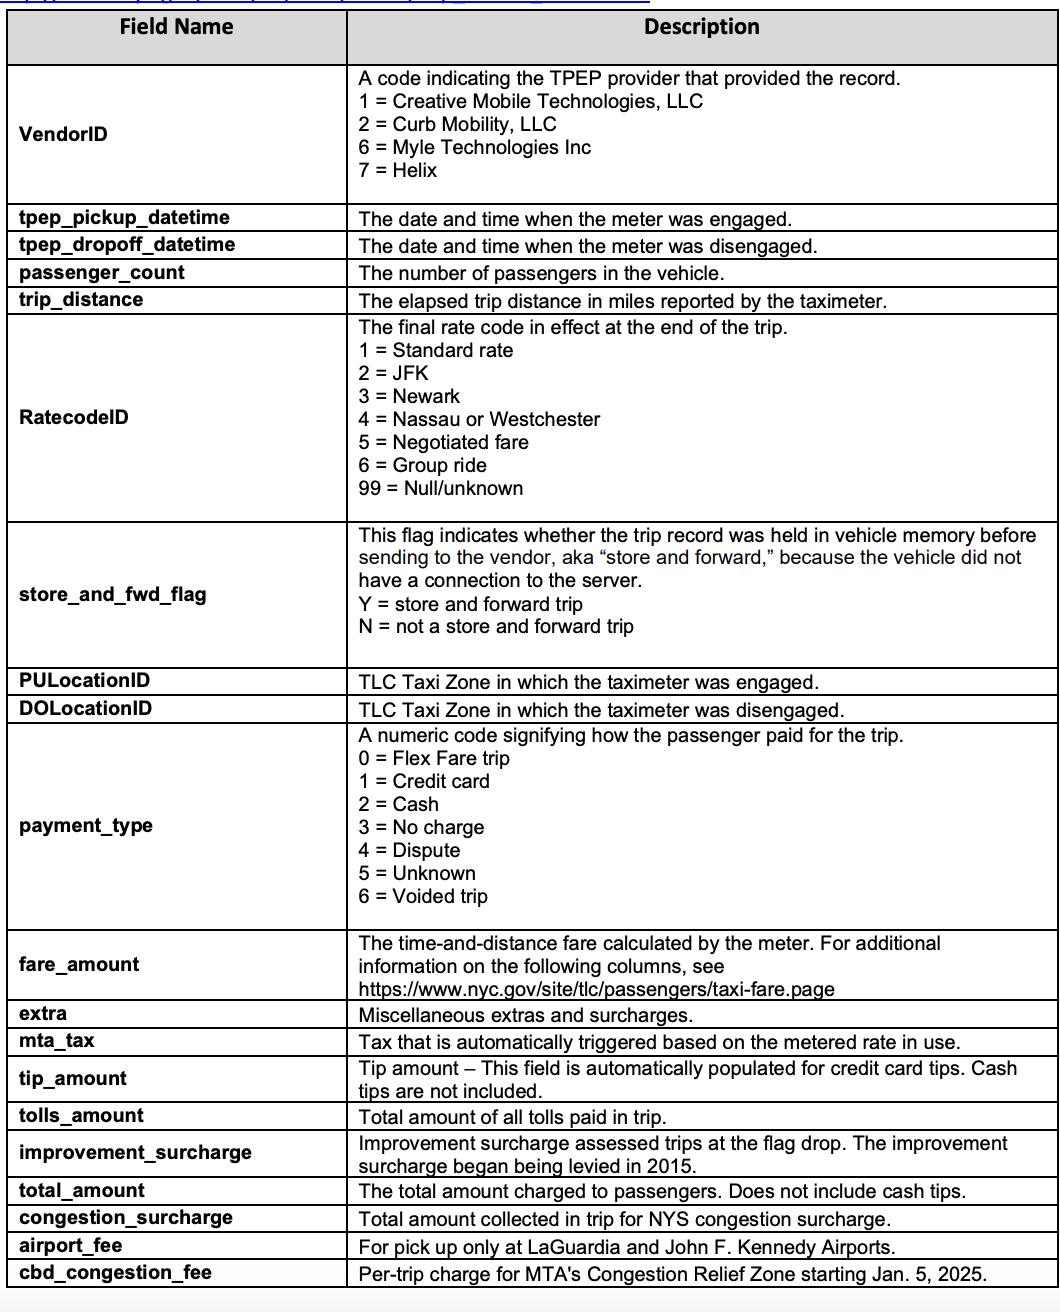

In [9]:
display(Image(filename="figura.png"))

# EDA

In [11]:
# See the schema (column names and types)
full_df.printSchema()

root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp_ntz (nullable = true)
 |-- tpep_dropoff_datetime: timestamp_ntz (nullable = true)
 |-- passenger_count: long (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: long (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- Airport_fee: double (nullable = true)
 |-- month: integer (nullable = false)



In [12]:
# Count total rows
print(f"Total rows: {full_df.count()}")

Total rows: 41169720


In [13]:
continuous_cols = [
    "trip_distance", "fare_amount", "tip_amount", "total_amount",
    "extra", "mta_tax", "tolls_amount", "improvement_surcharge",
    "congestion_surcharge", "Airport_fee"
]

In [14]:
# Get descriptive statistics from Spark
desc_df = full_df.select(continuous_cols).describe()

# Convert to pandas for nice formatting
desc_pd = desc_df.toPandas().set_index("summary").T

# Round values and display nicely

pd.set_option("display.max_columns", None)
display(desc_pd.round(2))

25/04/25 21:43:44 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


summary,count,mean,stddev,min,max
trip_distance,41169720,4.976100785237083,419.2304973495336,0.0,398608.62
fare_amount,41169720,19.268509729967903,76.71984026978751,-2261.2,335544.44
tip_amount,41169720,3.307884018642594,4.090523062522788,-300.0,999.99
total_amount,41169720,27.83281318699977,78.05358621902587,-2265.45,335550.94
extra,41169720,1.385953068905982,1.8158781232411494,-9.25,65.99
mta_tax,41169720,0.4797774084934267,0.13018302651337105,-0.5,41.3
tolls_amount,41169720,0.5615266120338764,2.2405452034368736,-140.63,1702.88
improvement_surcharge,41169720,0.9629933771713788,0.2550554462404921,-1.0,2.0
congestion_surcharge,37078488,2.2321442630023105,0.8746528269289681,-2.5,2.52
Airport_fee,37078488,0.14700596070691987,0.5020406813511821,-1.75,1.75


In [15]:
# Check for nulls in all columns (absolute and percentage)
print("\nNull values per column (%):")

total_rows = full_df.count()

for col in full_df.columns:
    nulls = full_df.filter(F.col(col).isNull()).count()
    if nulls > 0:
        percentage = (nulls / total_rows) * 100
        print(f"{col}: {nulls} nulls ({percentage:.2f}%)")


Null values per column (%):


passenger_count: 4091232 nulls (9.94%)


RatecodeID: 4091232 nulls (9.94%)


store_and_fwd_flag: 4091232 nulls (9.94%)
congestion_surcharge: 4091232 nulls (9.94%)
Airport_fee: 4091232 nulls (9.94%)


## Histogram Numerical Features

In [17]:
# Sample ~1% of the data
sample_df = full_df.sample(fraction=0.01, seed=42).toPandas()

In [18]:
# Continuous numerical features
continuous_cols = [
    "trip_distance", "fare_amount", "tip_amount", "total_amount",
    "extra", "mta_tax", "tolls_amount", "improvement_surcharge",
    "congestion_surcharge", "Airport_fee"
]

In [19]:
# Discrete numerical features
discrete_cols = [
    "passenger_count"
]

🔵 Continuous Numeric Features:


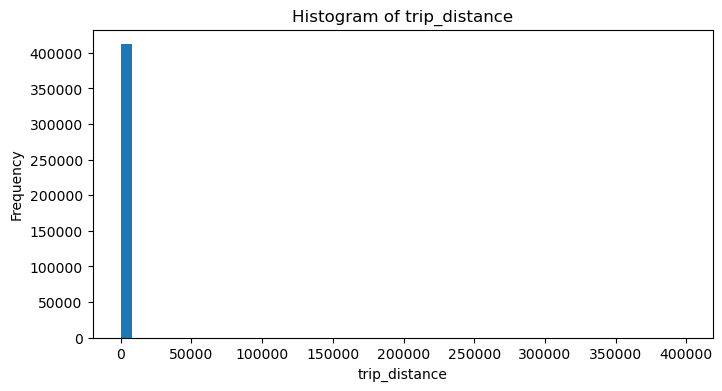

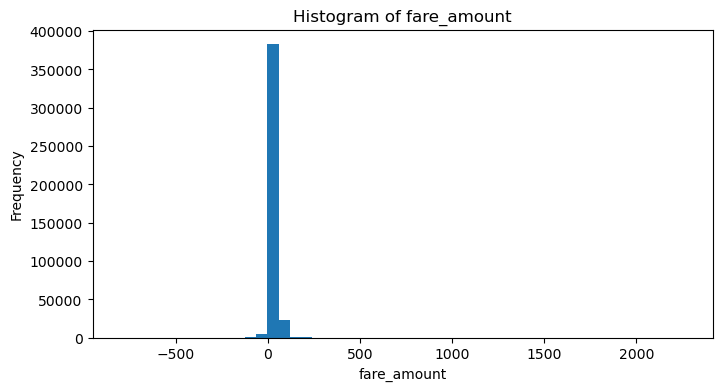

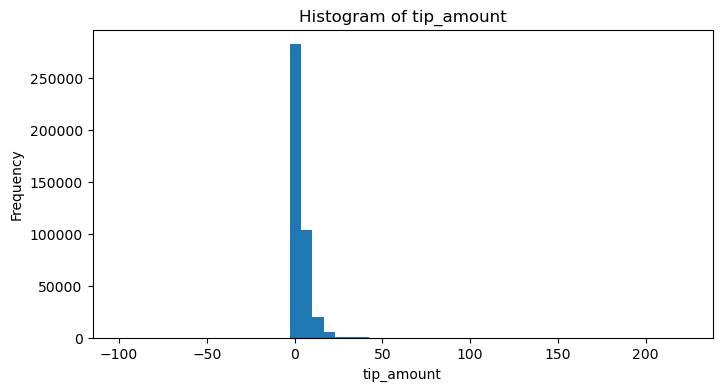

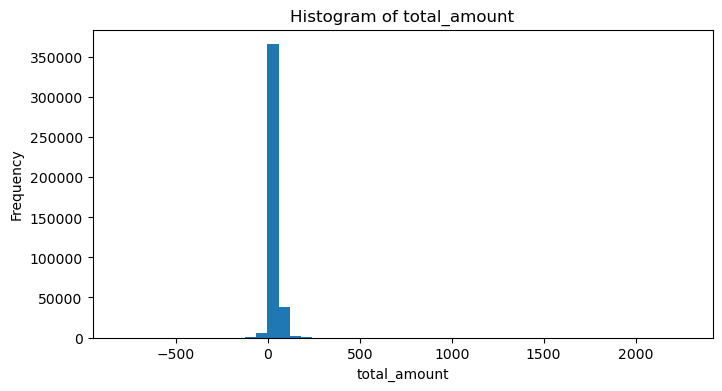

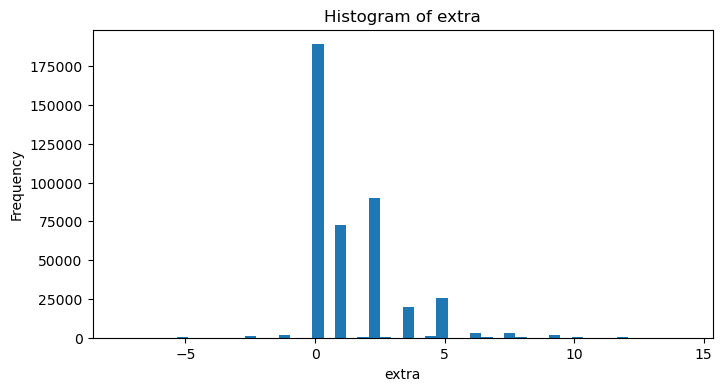

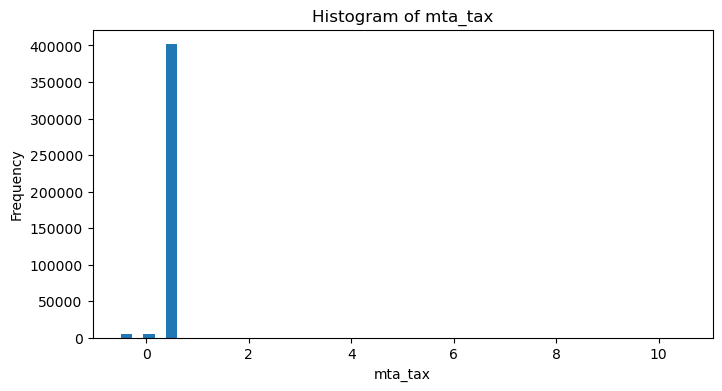

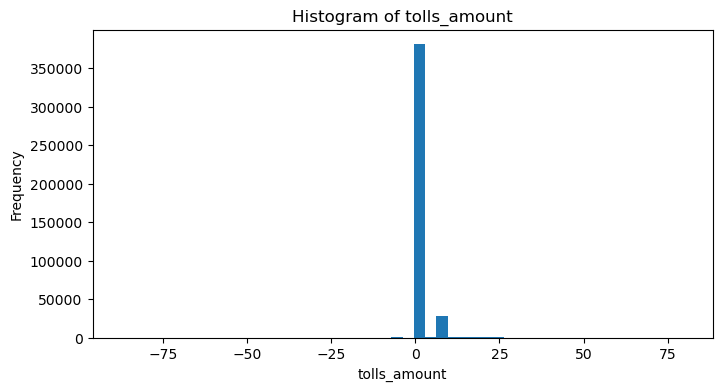

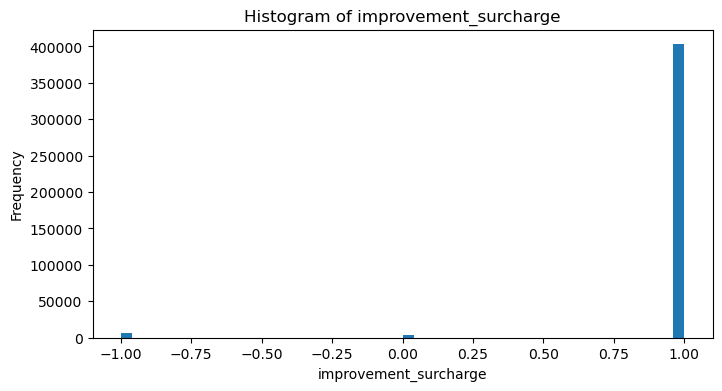

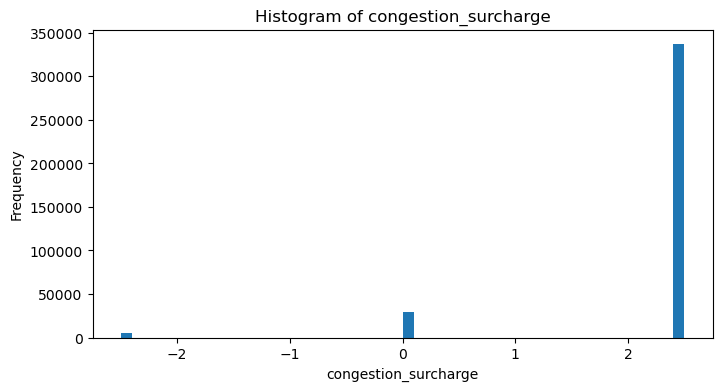

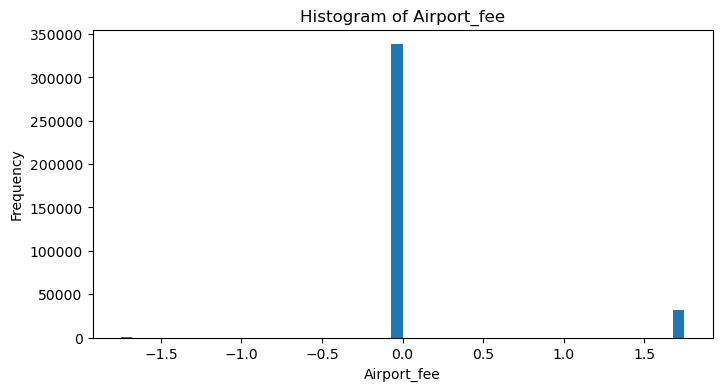

In [20]:
# Plot continuous features
print("🔵 Continuous Numeric Features:")
for col in continuous_cols:
    plt.figure(figsize=(8, 4))
    sample_df[col].hist(bins=50)
    plt.title(f"Histogram of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.grid(False)
    plt.show()

### Trip Distance

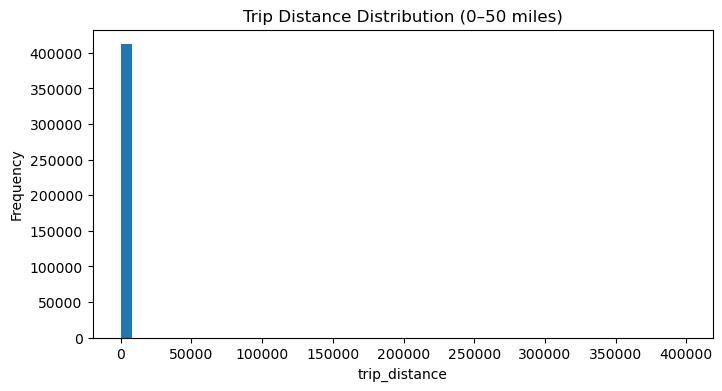

In [22]:
sample_df["trip_distance"].hist(bins=50, figsize=(8, 4))
plt.title("Trip Distance Distribution (0–50 miles)")
plt.xlabel("trip_distance")
plt.ylabel("Frequency")
plt.grid(False)
plt.show()

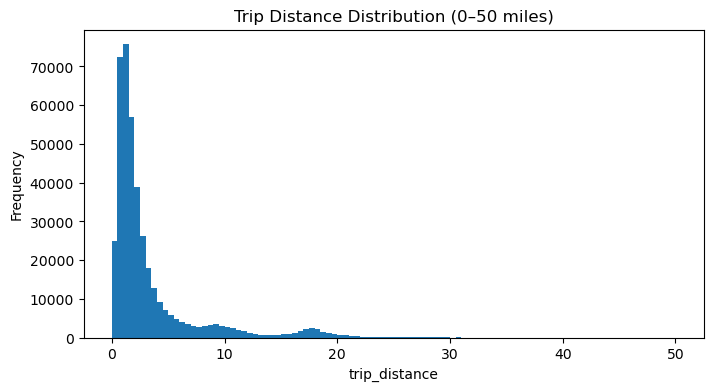

In [145]:
# Zoom in on trips up to 50 miles
sample_df["trip_distance"].hist(bins=100, range=(0, 50), figsize=(8, 4))
plt.title("Trip Distance Distribution (0–50 miles)")
plt.xlabel("trip_distance")
plt.ylabel("Frequency")
plt.grid(False)
plt.show()

### 📊 EDA Summary: `trip_distance`

- **Description:** Total distance of the trip in miles, as reported by the taximeter.
- **Typical values:** Most rides are under 2 miles; long tail extends to 50+ miles.
- **Skewness:** Strong right-skewed distribution — confirmed visually after zooming in.
- **Issues detected:**
  - Many rides have `trip_distance = 0.0` → likely invalid.
  - Outliers up to 398,000+ miles → clearly corrupt data.

---

#### ✅ Preprocessing Plan for this Feature:

- **Remove rows** where:
  - `trip_distance <= 0` (invalid trip)
  - `trip_distance > 100` (extreme outlier for NYC yellow taxis)
- **Optional:** log-transform or scale if using distance in regression or clustering


### Fare amount

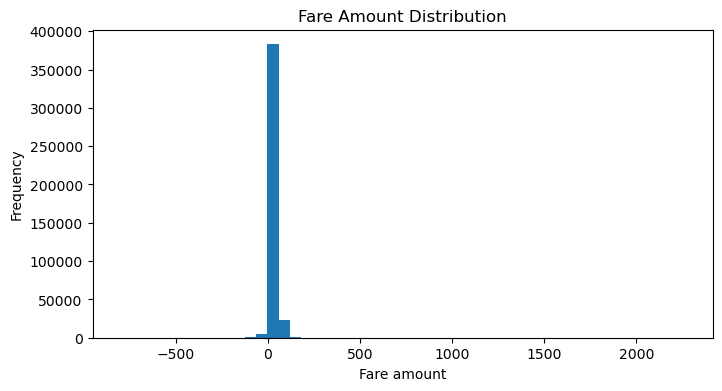

In [26]:
sample_df["fare_amount"].hist(bins=50, figsize=(8, 4))
plt.title("Fare Amount Distribution")
plt.xlabel("Fare amount")
plt.ylabel("Frequency")
plt.grid(False)
plt.show()

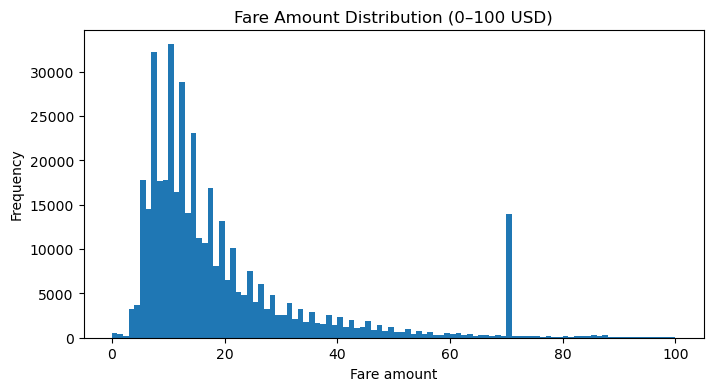

In [27]:
sample_df["fare_amount"].hist(bins=100, range=(0, 100), figsize=(8, 4))
plt.title("Fare Amount Distribution (0–100 USD)")
plt.xlabel("Fare amount")
plt.ylabel("Frequency")
plt.grid(False)
plt.show()

### 📊 EDA Summary: `fare_amount`

- **Description:** Metered fare amount charged for the trip (excludes tolls, tips, extras).
- **Distribution:**
  - Peaks around \$6–15 (typical short NYC rides).
  - Long right tail — some long-distance trips and flat-rate airport fares.
  - Spike at ~\$70 → likely flat-rate to/from JFK.
- **Issues detected:**
  - Negative fares (min = -2,261.29) → invalid
  - Outliers above \$500 → unrealistic

---

#### ✅ Preprocessing Plan:

- **Drop rows** where `fare_amount <= 0` or `fare_amount > 200`
- **Optional:** log-transform for regression models
- **Consider special handling** for fixed airport fare (e.g., \$52–\$70) if modeling pickup types


### Tip amount

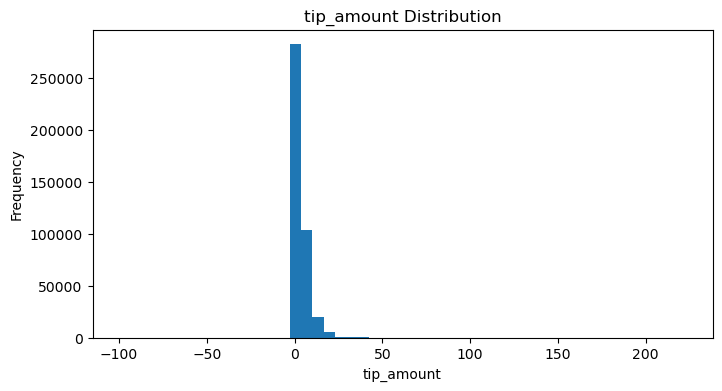

In [30]:
sample_df["tip_amount"].hist(bins=50, figsize=(8, 4))
plt.title("tip_amount Distribution")
plt.xlabel("tip_amount")
plt.ylabel("Frequency")
plt.grid(False)
plt.show()

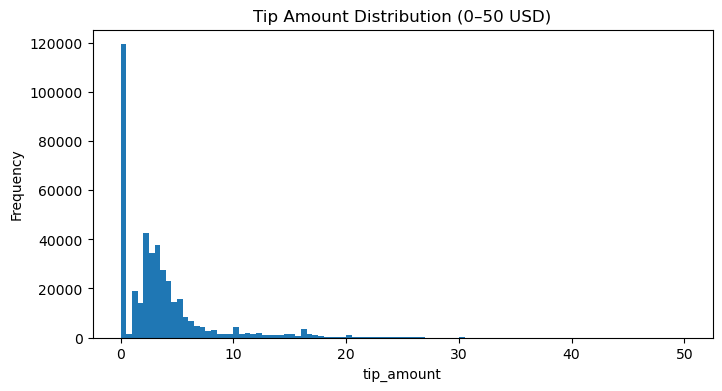

In [31]:
sample_df["tip_amount"].hist(bins=100, range=(0, 50), figsize=(8, 4))
plt.title("Tip Amount Distribution (0–50 USD)")
plt.xlabel("tip_amount")
plt.ylabel("Frequency")
plt.grid(False)
plt.show()

### 📊 EDA Summary: `tip_amount`

- **Description:** Tip given by passenger, automatically recorded for credit card payments.

- **Distribution:**
  - High spike at \$0 → dollars  ommon for cash trips or passengers who didn't tip.
  - Smooth right-skewed tail → tips up to \$50+ are possible.
  - A few very large values (up to 999.99) → likely outliers.

- **Issues detected:**
  - Negative tips (as low as -300) → invalid, must be removed.
  - Extreme outliers above 200 → should be removed or capped.

---

#### ✅ Preprocessing Plan:

- **Remove rows** where `tip_amount < 0` or `tip_amount > 200`
- **Optional:** log-transform or compute `tip_percentage = tip_amount / fare_amount`
- **Useful as target** for regression model or classification (tipped vs. not)


### Total amount

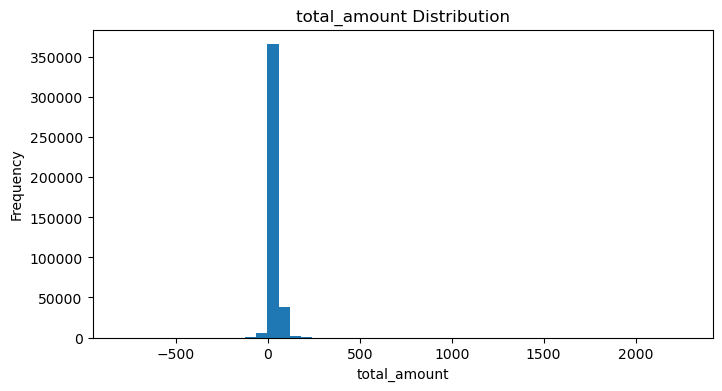

In [34]:
sample_df["total_amount"].hist(bins=50, figsize=(8, 4))
plt.title("total_amount Distribution")
plt.xlabel("total_amount")
plt.ylabel("Frequency")
plt.grid(False)
plt.show()

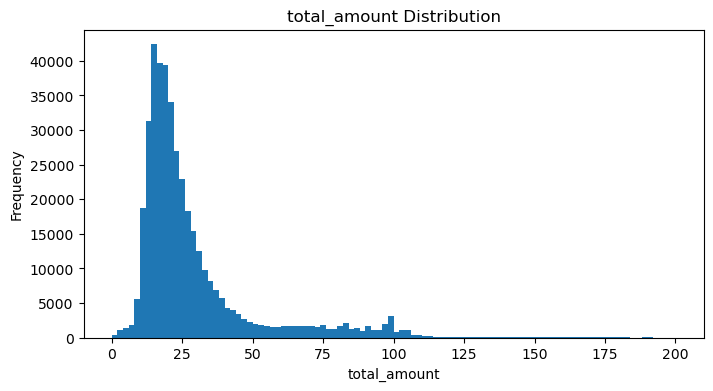

In [35]:
sample_df["total_amount"].hist(bins=100,range=(0, 200), figsize=(8, 4))
plt.title("total_amount Distribution")
plt.xlabel("total_amount")
plt.ylabel("Frequency")
plt.grid(False)
plt.show()

### 📊 EDA Summary: `total_amount`

- **Description:** Total amount charged to the passenger, including fare, surcharges, taxes, tolls, and tips.

- **Distribution:**
  - Right-skewed, with most values between \$5 and \$100.
  - Long tail with very high outliers up to \$335,550.94 (likely data errors).
  - High spike near \$0 and some negative values → clearly invalid.

- **Issues detected:**
  - **Negative values** (as low as -2,265.45) → invalid, must be removed.
  - **Outliers above $500** → extremely rare, likely incorrect or special cases.

---

#### ✅ Preprocessing Plan:

- **Remove rows** where `total_amount <= 0` or `total_amount > 200`
- **Optional:** log-transform or scale the variable depending on the model
- Useful for:
  - Predicting payment behavior
  - Understanding ride types or anomalies


### Extra

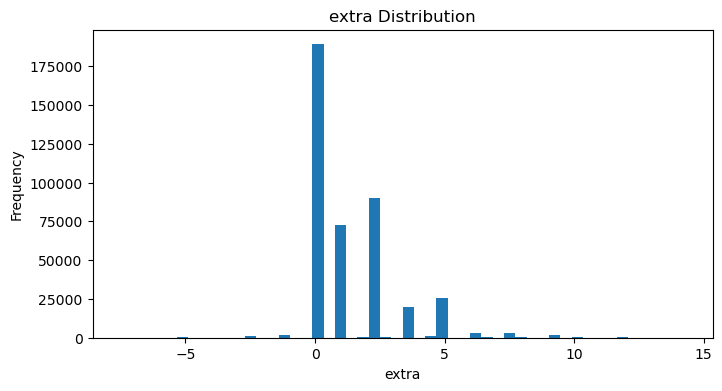

In [38]:
sample_df["extra"].hist(bins=50, figsize=(8, 4))
plt.title("extra Distribution")
plt.xlabel("extra")
plt.ylabel("Frequency")
plt.grid(False)
plt.show()

### 📊 EDA Summary: `extra`

- **Description:** Miscellaneous extras and surcharges, including night and peak-hour fees.

- **Distribution:**
  - Most common value: **0.0** (no extras)
  - Frequent values: **0.5**, **1.0**, **2.5**, **3.0**, **5.0**
  - A few high values up to 13 → possibly valid combinations
  - Some **negative values** detected → invalid

- **Issues detected:**
  - Negative `extra` values must be removed

---

#### ✅ Preprocessing Plan:

- **Remove rows** where `extra < 0`
- Keep values up to 13 (no need to cap — values seem legitimate)
- Can be used as a numeric feature or discretized if needed

### mta_tax

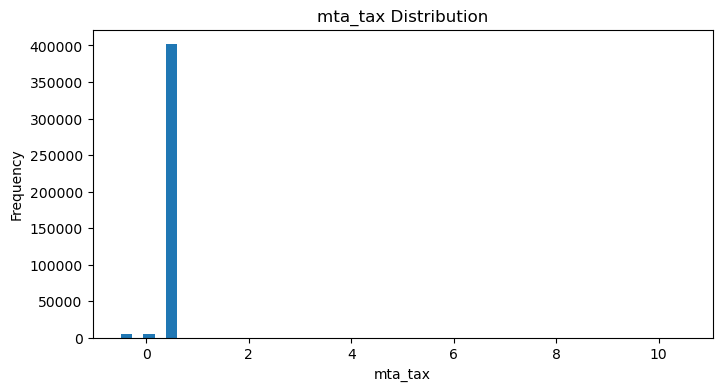

In [41]:
sample_df["mta_tax"].hist(bins=50, figsize=(8, 4))
plt.title("mta_tax Distribution")
plt.xlabel("mta_tax")
plt.ylabel("Frequency")
plt.grid(False)
plt.show()

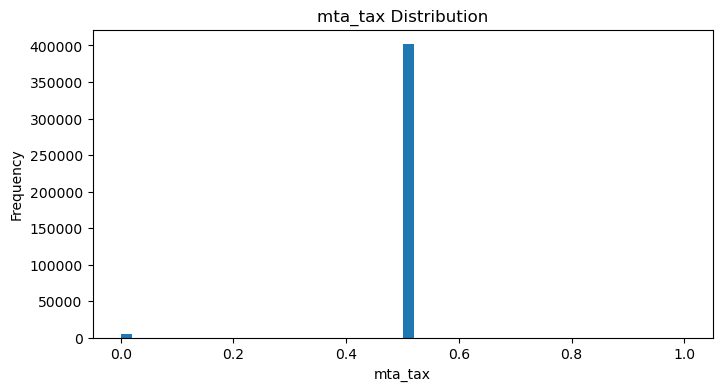

In [42]:
sample_df["mta_tax"].hist(bins=50,range=(0, 1), figsize=(8, 4))
plt.title("mta_tax Distribution")
plt.xlabel("mta_tax")
plt.ylabel("Frequency")
plt.grid(False)
plt.show()

In [43]:
full_df.groupBy("mta_tax") \
       .count() \
       .orderBy("count", ascending=False) \
       .show()

+-------+--------+
|mta_tax|   count|
+-------+--------+
|    0.5|40085950|
|   -0.5|  583161|
|    0.0|  500213|
|    1.0|     259|
|    4.0|      47|
|    3.0|      31|
|   10.5|      18|
|    0.8|       6|
|   3.25|       5|
|   5.75|       4|
|   0.16|       4|
|  -0.16|       3|
|    2.5|       3|
|   1.05|       3|
|    1.6|       1|
|    1.4|       1|
|    1.5|       1|
|  35.84|       1|
|   2.99|       1|
|   25.0|       1|
+-------+--------+
only showing top 20 rows



### 📊 EDA Summary: `mta_tax`

- **Description:** NYC MTA tax, typically fixed at $0.50 per trip.

- **Distribution:**
  - ✅ Most trips have a value of **0.5** (standard MTA tax).
  - ✅ A large number of trips have **0.0** → likely exempt or very short trips.
  - ❌ Some **negative values** (e.g., -0.5, -0.16) → invalid.
  - ❌ A few **outlier values** (e.g., 1.0, 3.0, 3.5) → not standard, likely erroneous.

---

#### ✅ Preprocessing Plan:

- **Keep rows** where `mta_tax ∈ {0.0, 0.5}`
- **Remove rows** with `mta_tax < 0` or `mta_tax > 0.5`
- Optional: create binary column `has_mta_tax = mta_tax == 0.5`

### Tolls Amount

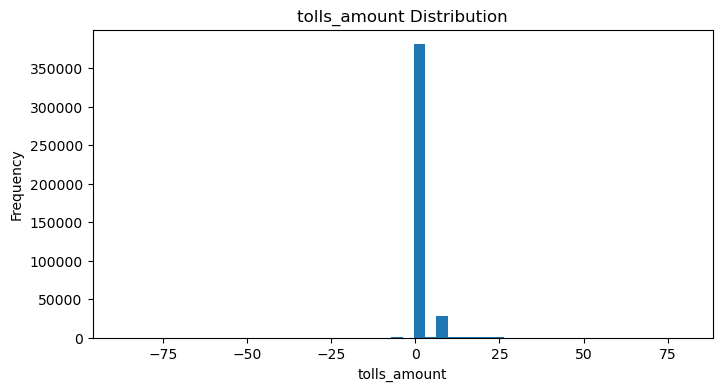

In [46]:
sample_df["tolls_amount"].hist(bins=50, figsize=(8, 4))
plt.title("tolls_amount Distribution")
plt.xlabel("tolls_amount")
plt.ylabel("Frequency")
plt.grid(False)
plt.show()

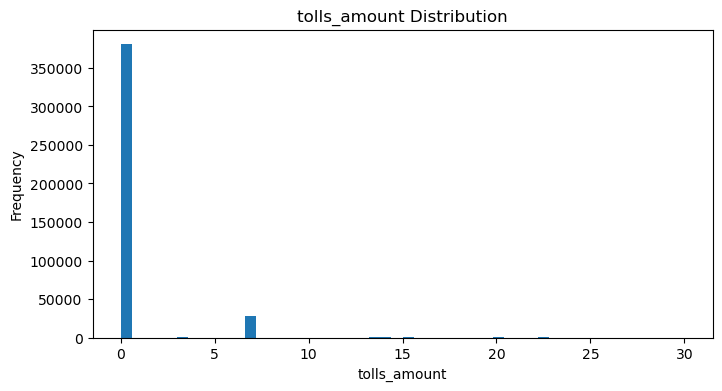

In [162]:
sample_df["tolls_amount"].hist(bins=50,range=(0,30), figsize=(8, 4))
plt.title("tolls_amount Distribution")
plt.xlabel("tolls_amount")
plt.ylabel("Frequency")
plt.grid(False)
plt.show()

In [48]:
full_df.groupBy("tolls_amount") \
       .count() \
       .orderBy("count", ascending=False) \
       .show()

+------------+--------+
|tolls_amount|   count|
+------------+--------+
|         0.0|38034236|
|        6.94| 2821587|
|       13.38|   43635|
|       -6.94|   41525|
|       15.38|   34842|
|        3.18|   20985|
|       13.88|   19964|
|       20.32|    7767|
|       22.32|    6216|
|         5.2|    6037|
|       11.19|    4715|
|         2.0|    4203|
|       21.38|    3967|
|       20.38|    3892|
|       20.82|    2928|
|       22.38|    2872|
|       23.38|    2787|
|       11.94|    2772|
|         3.0|    2664|
|       18.38|    2641|
+------------+--------+
only showing top 20 rows



### 📊 EDA Summary: `tolls_amount`

- **Description:** Total tolls charged during the trip (e.g., bridges, tunnels, toll roads).

- **Distribution:**
  - ✅ Most trips: `tolls_amount = 0.0` (no tolls paid).
  - ✅ Common positive values (e.g., 6.94, 13.38) → reflect standard NYC tolls.
  - ❌ Some **negative values** → invalid.
  - Skewed distribution, but usable as-is after basic cleaning.

---

#### ✅ Preprocessing Plan:

- **Remove rows** where `tolls_amount < 0`
- **Keep as numeric** — can be useful for total cost modeling or clustering.
- Optional: create a binary feature `has_toll = tolls_amount > 0`

### Improvement Surcharge

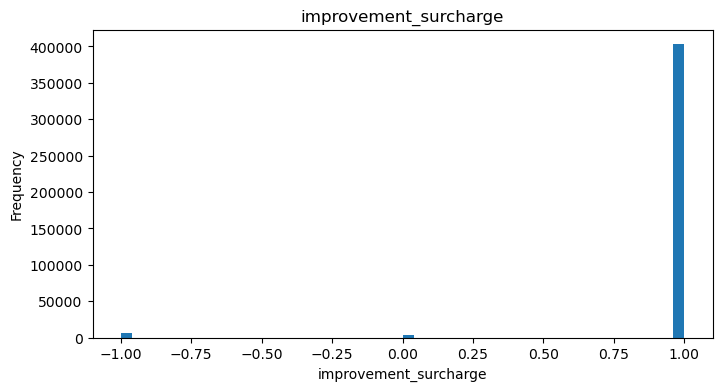

In [51]:
    plt.figure(figsize=(8, 4))
    sample_df['improvement_surcharge'].hist(bins=50)
    plt.title("improvement_surcharge")
    plt.xlabel("improvement_surcharge")
    plt.ylabel("Frequency")
    plt.grid(False)
    plt.show()

In [52]:
full_df.groupBy("improvement_surcharge") \
       .count() \
       .orderBy("count", ascending=False) \
       .show()

+---------------------+--------+
|improvement_surcharge|   count|
+---------------------+--------+
|                  1.0|40250612|
|                 -1.0|  606107|
|                  0.0|  307455|
|                  0.3|    5539|
|                 -0.3|       5|
|                  2.0|       1|
|                  0.5|       1|
+---------------------+--------+



### 📊 EDA Summary: `improvement_surcharge`

- **Description:** A fixed fee per trip meant to fund taxi improvements and driver benefits, introduced in 2015.
- **Expected Value:** $0.30 per trip (though some records show `1.0`, likely due to rounding or multiple surcharges).

---

#### 🔍 Distribution:

| Value | Count | Interpretation |
|-------|-------|----------------|
| `1.0` | 40.25M | ✅ Most common and considered valid |
| `0.3` | 5.5K   | ✅ Accurate per TLC policy |
| `0.0` | 307K   | ⚠️ Possibly missing/unreported — could impute |
| `-1.0` | 606K | ❌ Invalid, negative fee — should be removed |
| `-0.3` | 5     | ❌ Invalid |
| `0.5` / `2.0` | 1 each | ❌ Outliers or data entry errors |

---

#### ✅ Preprocessing Plan for this Feature:

- **Keep:** rows where `improvement_surcharge ∈ {0.3, 1.0}`
- **Replace:** `0.0 → 1.0` (optional, mode imputation)
- **Remove:** rows where value `< 0` or `> 1.0`

---

✅ This variable has **almost no variance**, but we’ll keep it for completeness.  
We may later test its impact on the model and drop it if it has low feature importance.

### congestion_surcharge

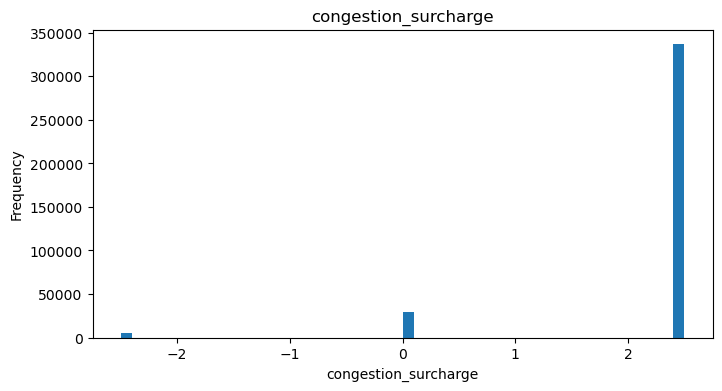

In [55]:
sample_df["congestion_surcharge"].hist(bins=50, figsize=(8, 4))
plt.title("congestion_surcharge")
plt.xlabel("congestion_surcharge")
plt.ylabel("Frequency")
plt.grid(False)
plt.show()

In [56]:
full_df.groupBy("congestion_surcharge") \
       .count() \
       .orderBy("count", ascending=False) \
       .show()

+--------------------+--------+
|congestion_surcharge|   count|
+--------------------+--------+
|                 2.5|33601544|
|                NULL| 4091232|
|                 0.0| 2981167|
|                -2.5|  495742|
|                 1.0|      18|
|                0.75|      12|
|               -0.75|       3|
|                 2.0|       1|
|                2.52|       1|
+--------------------+--------+



### 📊 EDA Summary: `congestion_surcharge`

- **Description:** Extra fee charged for trips starting, ending, or passing through NYC congestion zones (e.g., Manhattan south of 96th Street).

- **Distribution:**
  - ✅ Most trips have a surcharge of **2.5 USD** (expected standard).
  - ✅ A substantial number have **0.0 USD** (trips outside the congestion zone).
  - ⚠️ Over **4 million NULL values** — potentially trips before the surcharge was implemented or missing data.
  - ❌ Negative values (e.g., -2.5, -0.75) detected — invalid.
  - ❓ Rare unexpected values like **0.75**, **1.0**, **2.0**, **2.52** suggest potential data entry issues.

---

#### ✅ Preprocessing Plan (planned, not applied yet):

- **Remove rows** where `congestion_surcharge < 0`
- **Handle NULL values:**
  - Option 1: Fill with `0.0`
  - Option 2: Fill with the mode (`2.5`) or drop, depending on project goals
- **Consider creating a binary feature** (`has_congestion_fee`)

### airport_fee

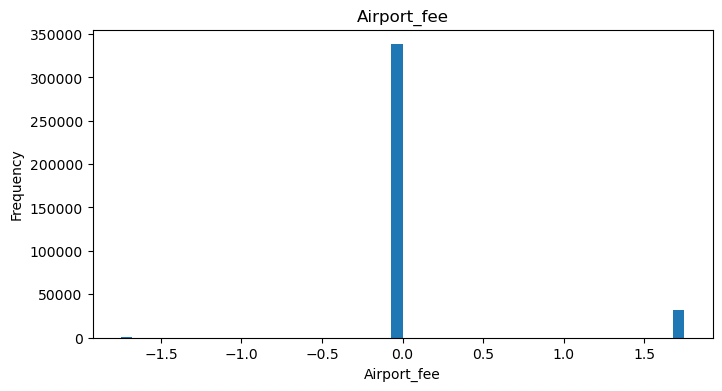

In [59]:
sample_df["Airport_fee"].hist(bins=50, figsize=(8, 4))
plt.title("Airport_fee")
plt.xlabel("Airport_fee")
plt.ylabel("Frequency")
plt.grid(False)
plt.show()

In [60]:
full_df.groupBy("Airport_fee") \
       .count() \
       .orderBy("count", ascending=False) \
       .show()

+-----------+--------+
|Airport_fee|   count|
+-----------+--------+
|        0.0|33765255|
|       NULL| 4091232|
|       1.75| 3213953|
|      -1.75|   99253|
|       1.25|      27|
+-----------+--------+



### 📊 EDA Summary: `Airport_fee`

- **Description:** Fixed surcharge applied to taxi trips originating from JFK and LaGuardia airports.

- **Distribution:**
  - ✅ Majority of trips have `0.0` → non-airport trips.
  - ✅ About 3.2 million trips correctly charged `1.75`.
  - ⚠️ Around 4 million NULL entries (missing or unrecorded airport info).
  - ❌ Negative values (e.g., -1.75) detected — invalid.
  - ❓ Rare unexpected value (`1.25`) — very few occurrences, possibly old pricing.

---

#### ✅ Preprocessing Plan:

- **Remove rows** where `Airport_fee < 0`
- **Optionally:** Fill NULLs with `0.0` if assuming missing = no airport fee
- **Optional:** Create binary feature (`has_airport_fee`)

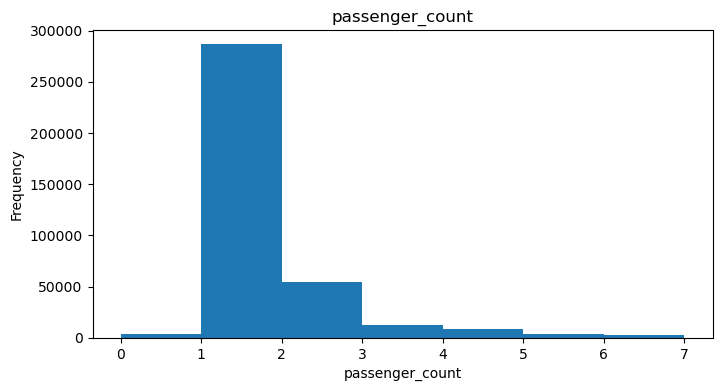

In [62]:
sample_df["passenger_count"].hist(bins=7, figsize=(8, 4))
plt.title("passenger_count")
plt.xlabel("passenger_count")
plt.ylabel("Frequency")
plt.grid(False)
plt.show()

### 👤 EDA Summary: `passenger_count`

- **Description:** Number of passengers in the taxi trip. Should be between 1 and 5 for typical NYC yellow taxi rides.

- **Distribution:**
  - ✅ Most trips have **1 passenger**, as expected.
  - ✅ Other common values include 2–4 passengers.
  - ⚠️ A few trips with **6 or 7 passengers** — may reflect large groups or van service.
  - ❌ Some trips report **0 passengers** — invalid or unrecorded.

---

#### ✅ Preprocessing Plan:

- **Remove** or **impute** rows with `passenger_count == 0`
- **Optionally:** Treat as categorical (since it's a discrete count)
- Consider creating a **binary flag** like `is_shared_ride` (e.g. `passenger_count > 1`)


# Categorical Features

In [65]:
full_df.groupBy("VendorID").count().orderBy("count", ascending=False).show()


+--------+--------+
|VendorID|   count|
+--------+--------+
|       2|31451503|
|       1| 9715918|
|       6|    2069|
|       7|     230|
+--------+--------+



### 🏷️ Categorical Feature Summary: `VendorID`

- **Description:** Identifies the TPEP (Technology Passenger Enhancement Program) provider that submitted the trip record.
  - `1` = Creative Mobile Technologies, LLC  
  - `2` = Curb Mobility, LLC  
  - `6` = Myle Technologies Inc  
  - `7` = Helix

- **Distribution:**
  - `2` (Curb Mobility) is the dominant provider with over 31 million records (~76%).
  - `1` (Creative Mobile Technologies) is also frequent (~23%).
  - `6` and `7` are rare and likely represent niche or recent entries in the system.

- **Notes:**
  - Can be treated as **categorical** (e.g. one-hot encoding).
  - Rare values (`6`, `7`) may be grouped into an **"Other"** category depending on modeling strategy.

### RatecodeID

In [68]:
full_df.groupBy("RatecodeID").count().orderBy("count", ascending=False).show()


+----------+--------+
|RatecodeID|   count|
+----------+--------+
|         1|34651027|
|      NULL| 4091232|
|         2| 1406870|
|        99|  466974|
|         5|  321948|
|         3|  129951|
|         4|  101642|
|         6|      76|
+----------+--------+



### 🏷️ Categorical Feature Summary: `RatecodeID`

- **Description:** Indicates the final rate code used to compute the fare.

- **Distribution:**
  - ✅ `1` (Standard rate) is dominant (≈34.6M trips).
  - ✅ `2` (JFK) is frequent (~1.4M trips).
  - ⚠️ `99` (Unknown) appears in ~467K trips → represents missing or unknown rate coding.
  - ⚠️ `5`, `3`, `4` appear but are relatively rare.
  - ❌ `6` (Group ride) appears only **76 times** — extremely rare.

- **Issues detected:**
  - High number of **NULL values** (~4M trips) → should be handled during preprocessing.

---

#### ✅ Preprocessing Plan (planned, not applied yet):

- **Treat as categorical** (string).
- **Optionally group** very rare categories (`4`, `5`, `6`, `99`) into an **"Other"** class.
- **Decide how to handle NULLs:** fill as "Unknown" or separate category.

### store_and_fwd_flag

In [71]:
full_df.groupBy("store_and_fwd_flag").count().orderBy("count", ascending=False).show()


+------------------+--------+
|store_and_fwd_flag|   count|
+------------------+--------+
|                 N|36903316|
|              NULL| 4091232|
|                 Y|  175172|
+------------------+--------+



### 🏷️ Categorical Feature Summary: `store_and_fwd_flag` (maybe this is not relavant)

- **Description:** Indicates whether the trip record was stored in the vehicle memory before sending to the server.
  - `Y` = Stored and forwarded later (vehicle had no connection at pickup/dropoff time).
  - `N` = Sent directly to the server at the time of trip.

- **Distribution:**
  - ✅ `N` (No delay) is dominant — ~36.9M trips (~90%).
  - ✅ `Y` (Stored and forwarded) occurs in ~175K trips (~0.4%).
  - ⚠️ About 4M trips have **NULL values** — possibly older records or missing transmission info.

- **Issues detected:**
  - NULL values (~10% of total) — should be handled during preprocessing.

---

#### ✅ Preprocessing Plan (planned, not applied yet):

- **Treat as binary categorical** (`N`, `Y`).
- **Handle NULLs:** 
  - Option 1: Fill with `N` (assuming majority behavior).
  - Option 2: Introduce a third category ("Unknown") if more careful treatment is needed.

### payment_type

In [74]:
full_df.groupBy("payment_type").count().orderBy("count", ascending=False).show()

+------------+--------+
|payment_type|   count|
+------------+--------+
|           1|30452159|
|           2| 5540088|
|           0| 4091232|
|           4|  794494|
|           3|  291743|
|           5|       4|
+------------+--------+



### 🏷️ Categorical Feature Summary: `payment_type`

- **Description:** A numeric code signifying how the passenger paid for the trip.


- **Distribution:**
  - ✅ `1` (Credit Card) dominates — 30.4M trips (~73%).
  - ✅ `2` (Cash) — 5.5M trips (~13%).
  - ⚠️ `0` (Flex Fare Trip) — 4M trips (10%).
  - ⚠️ `3` (No Charge) and `4` (Dispute) are rare but valid cases.
  - ❌ `5` (Unknown) has only 4 trips — likely noise.

- **Issues detected:**
  - Flex Fare trips (`0`) are meaningful (not "unknown" — it's a specific payment type).
  - Category `5` is extremely rare — might be grouped or ignored.

---

#### ✅ Preprocessing Plan (planned, not applied yet):

- **Treat as categorical** (use StringIndexer or similar).
- **Keep Flex Fare trips (`0`)** as a valid category.
- **Group very rare classes** (`5`) into "Other" if needed or delete.


### PULocationID

In [77]:
full_df.groupBy("PULocationID").count().orderBy("count", ascending=True).show()

+------------+-----+
|PULocationID|count|
+------------+-----+
|         110|    1|
|         105|    4|
|          99|    4|
|           5|    7|
|         199|   17|
|         204|   18|
|          84|   21|
|          44|   23|
|         176|   38|
|         187|   38|
|         109|   39|
|         245|   46|
|         206|   61|
|         156|   62|
|           2|   62|
|         111|   75|
|         251|   78|
|          30|   96|
|         172|  101|
|         118|  102|
+------------+-----+
only showing top 20 rows



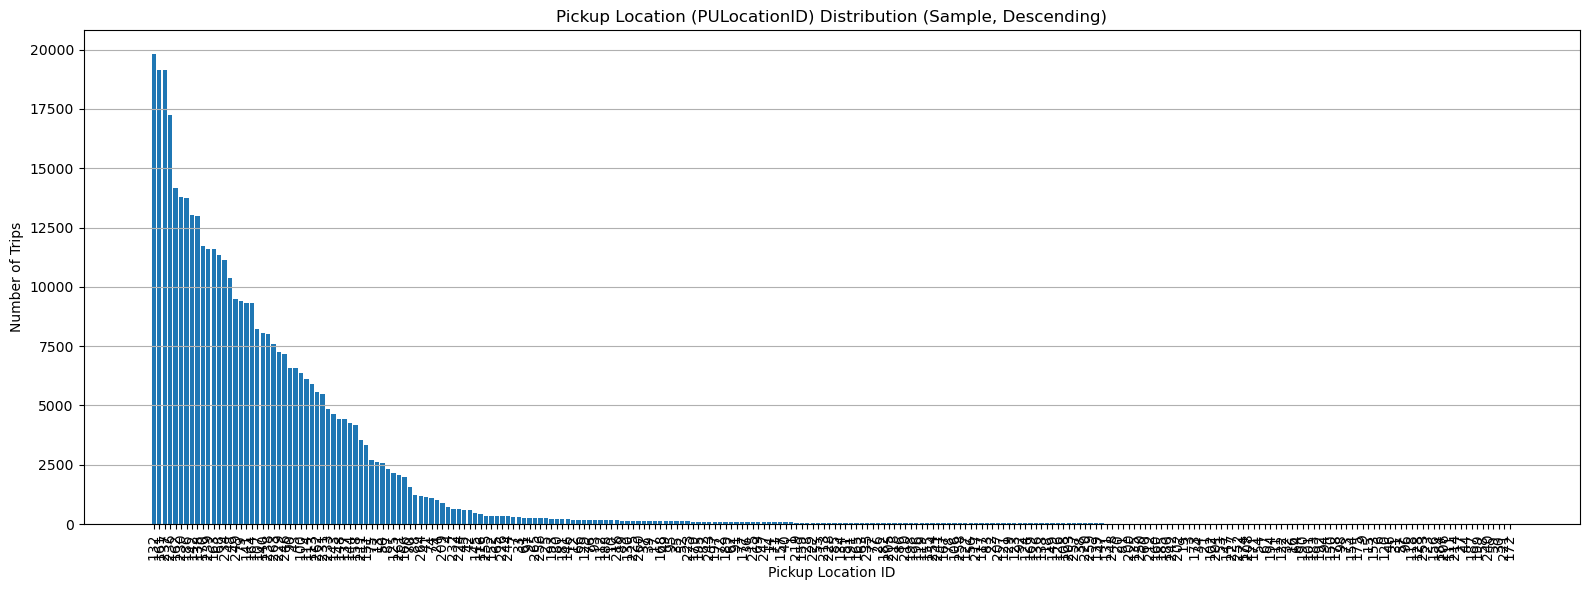

In [78]:
# Group sample by PULocationID
pu_counts_sample = sample_df.groupby("PULocationID").size().reset_index(name="count")

# Sort by count descending
pu_counts_sample = pu_counts_sample.sort_values("count", ascending=False)


plt.figure(figsize=(16,6))
plt.bar(pu_counts_sample["PULocationID"].astype(str), pu_counts_sample["count"])
plt.title("Pickup Location (PULocationID) Distribution (Sample, Descending)")
plt.xlabel("Pickup Location ID")
plt.ylabel("Number of Trips")
plt.xticks(rotation=90, ha='center')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

### 📊 EDA Summary: `PULocationID` & `DOLocationID`

- **Description:**  
  - `PULocationID`: TLC Taxi Zone ID where the meter was **engaged** (pickup).
  - `DOLocationID`: TLC Taxi Zone ID where the meter was **disengaged** (dropoff).
  - These IDs correspond to geographical taxi zones in NYC.

- **Distribution Insights:**
  - **Highly skewed**: A small number of zones account for the majority of pickups and dropoffs.
  - **Long tail**: Many zones have very few records.
  - **Zone pairing** could capture meaningful patterns in typical travel routes.


---

#### ✅ Preprocessing Plan:

- Treat IDs as **categorical strings** (not numerical).
- **Optionally create** a combined feature: `PU_DO_pair = PULocationID_DOLocationID`  
  → Useful for route-based analysis or clustering.




# Save de Dataset

In [81]:
full_df.write.mode("overwrite").parquet("full_dataset_after_eda.parquet")

25/04/25 21:44:18 WARN MemoryManager: Total allocation exceeds 95,00% (1 020 054 720 bytes) of heap memory
Scaling row group sizes to 95,00% for 8 writers
25/04/25 21:44:18 WARN MemoryManager: Total allocation exceeds 95,00% (1 020 054 720 bytes) of heap memory
Scaling row group sizes to 95,00% for 8 writers
25/04/25 21:44:21 WARN MemoryManager: Total allocation exceeds 95,00% (1 020 054 720 bytes) of heap memory
Scaling row group sizes to 95,00% for 8 writers
25/04/25 21:44:22 WARN MemoryManager: Total allocation exceeds 95,00% (1 020 054 720 bytes) of heap memory
Scaling row group sizes to 95,00% for 8 writers
25/04/25 21:44:22 WARN MemoryManager: Total allocation exceeds 95,00% (1 020 054 720 bytes) of heap memory
Scaling row group sizes to 95,00% for 8 writers
25/04/25 21:44:22 WARN MemoryManager: Total allocation exceeds 95,00% (1 020 054 720 bytes) of heap memory
Scaling row group sizes to 95,00% for 8 writers
25/04/25 21:44:22 WARN MemoryManager: Total allocation exceeds 95,00% 